<a href="https://www.kaggle.com/aurelianjohnherpin/next-human-milestones?scriptVersionId=89059584" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install and load libraries

In [1]:
!pip install openpyxl
!pip install geocoder

     |████████████████████████████████| 242 kB 918 kB/s            
     |████████████████████████████████| 98 kB 1.1 MB/s            


In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ephem
import geocoder
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Intro

Are we on track to address humanity's current big challenges? Specifically, on a global level, are we moving towards the following goals:

* Fully renewable energy use

* Electricity and internet access for all

* Sufficient food for everyone

* Achieving gender equality when it comes to sovereignty

And if we are, when can we expect to meet these goals?

On a country-level, which nations will achieve these goals first?

Remark: In this mini data analytics project, real data is used. However, the analysis does not aim to go in-depth nor provide sophisticated models and robust predictions. Nonetheless, interesting insights and trends into the current world evolution regarding crucial human metrics are displayed.

# Read data

**Dataset**

In this notebook, we will work with the "World Sustainability Dataset":

https://www.kaggle.com/truecue/worldsustainabilitydataset


**Description**:

"A ‘global sustainability’ dataset has been put together for the TrueCue Women+Data Hackathon. The dataset tracks the performance of 173 countries against a range of sustainability metrics over a 19-year period.

The dataset was generated from several merged data sources. While there 54 fields included, participants are not expected, nor advised to analyse the whole data. On the contrary, the wide nature of the dataset should give rise to a range of analytical possibilities.

Please note that the data is real. This presents all the challenges of working with data in professional world, such as missing values. For instance, a given country may not have data available for every field and every year."

In [3]:
data_df = pd.read_csv(
    "/kaggle/input/worldsustainabilitydataset/WorldSustainabilityDataset.csv"
)
data_df.head()

,Country Name,Country Code,Year,Access to electricity (% of population) - EG.ELC.ACCS.ZS,Adjusted net national income per capita (annual % growth) - NY.ADJ.NNTY.PC.KD.ZG,"Adjusted net savings, excluding particulate emission damage (% of GNI) - NY.ADJ.SVNX.GN.ZS",Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS,Adjusted savings: natural resources depletion (% of GNI) - NY.ADJ.DRES.GN.ZS,Adjusted savings: net forest depletion (% of GNI) - NY.ADJ.DFOR.GN.ZS,Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS,...,Gini index (World Bank estimate) - SI.POV.GINI,Income Classification (World Bank Definition),Individuals using the Internet (% of population) - IT.NET.USER.ZS,"Life expectancy at birth, total (years) - SP.DYN.LE00.IN","Population, total - SP.POP.TOTL",Regime Type (RoW Measure Definition),Rural population (% of total population) - SP.RUR.TOTL.ZS,Total natural resources rents (% of GDP) - NY.GDP.TOTL.RT.ZS,Urban population (% of total population) - SP.URB.TOTL.IN.ZS,World Regions (UN SDG Definition)
0,Aruba,ABW,2000,91.660398,NaN,15.392211,2.389134,0.000190,0.000190,NaN,...,NaN,High income,NaN,NaN,NaN,NaN,53.283,NaN,NaN,Latin America and Caribbean
1,Aruba,ABW,2001,100.000000,NaN,11.491930,2.509046,0.000214,0.000214,NaN,...,NaN,High income,17.1,73.853,92892.0,NaN,53.661,0.000712,46.339,Latin America and Caribbean
2,Aruba,ABW,2002,100.000000,NaN,3.893620,2.721385,0.000223,0.000223,NaN,...,NaN,High income,18.8,73.937,94992.0,NaN,54.028,0.000657,45.972,Latin America and Caribbean
3,Aruba,ABW,2003,100.000000,NaN,6.713863,2.733676,0.000243,0.000243,NaN,...,NaN,High income,20.8,74.038,97016.0,NaN,54.394,0.000700,45.606,Latin America and Caribbean
4,Aruba,ABW,2004,100.000000,NaN,9.801576,2.678363,0.000256,0.000256,NaN,...,NaN,High income,23.0,74.156,98744.0,NaN,54.760,0.000685,45.240,Latin America and Caribbean


Here, we will only explore the following features:

* **W**omen in parliament
* **I**nternet access
* **C**ountry
* **E**lectricity access
* Renewable **e**nergy consumption
* **Y**ear
* **U**ndernourishment

We copy and rename these columns in a sub-dataframe:

In [4]:
new_colnames_ls = [
    "country",
    "year",
    "energy",
    "electricity",
    "women",
    "internet",
    "undernourishment"
]
old_colnames_ls = [
    "Country Name",
    "Year",
    ("Renewable energy consumption (% of total "
     "final energy consumption) - EG.FEC.RNEW.ZS"),
    "Access to electricity (% of population) - EG.ELC.ACCS.ZS",
    ("Proportion of seats held by women in "
     "national parliaments (%) - SG.GEN.PARL.ZS"),
    "Individuals using the Internet (% of population) - IT.NET.USER.ZS",
    "Prevalence of undernourishment (%) - SN_ITK_DEFC - 2.1.1"
]
colname_dct = dict(zip(old_colnames_ls, new_colnames_ls))
WICEYU_df = data_df.rename(columns=colname_dct)[new_colnames_ls]
WICEYU_df.head()

,country,year,energy,electricity,women,internet,undernourishment
0,Aruba,2000,0.1753,91.660398,NaN,NaN,NaN
1,Aruba,2001,0.1805,100.000000,NaN,17.1,NaN
2,Aruba,2002,0.1814,100.000000,NaN,18.8,NaN
3,Aruba,2003,0.1846,100.000000,NaN,20.8,NaN
4,Aruba,2004,0.1871,100.000000,NaN,23.0,NaN


Get info about data:

In [5]:
info_df = pd.read_excel(
    "/kaggle/input/worldsustainabilitydataset/Data Dictionary.xlsx",
    header=1
)
info_df.head()

,Use,Associated SDG GOAL,Field,Code,Type,Description,Source,URL
0,World Bank,Goal 10. Reduce inequality within and among co...,Gini index (World Bank estimate),SI.POV.GINI,NaN,Score awarded based on how equitably income is...,World Bank Data Bank,DataBank | The World Bank
1,NaN,NaN,Adjusted net national income per capita (annua...,NY.ADJ.NNTY.PC.KD.ZG,NaN,Percentage yearly growth of adjusted net natio...,World Bank Data Bank,DataBank | The World Bank
2,NaN,Goal 3. Ensure healthy lives and promote well-...,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,NaN,Value which captures the expectated age a newb...,World Bank Data Bank,DataBank | The World Bank
3,NaN,Goal 13. Take urgent action to combat climate ...,"Adjusted net savings, excluding particulate em...",NY.ADJ.SVNX.GN.ZS,NaN,Measure that monitors whether savings and inve...,World Bank Data Bank,DataBank | The World Bank
4,NaN,NaN,Adjusted savings: carbon dioxide damage (% of ...,NY.ADJ.DCO2.GN.ZS,NaN,Measure that monitors whether savings and inve...,World Bank Data Bank,DataBank | The World Bank


In [6]:
for colname_old in old_colnames_ls[2:]:

    colname_new = colname_dct[colname_old]

    code = colname_old[-14:]
    df_filter = info_df['Code'].str.contains(code, na=False)

    info = info_df.loc[df_filter][["Description"]].values[0][0]
    source = info_df.loc[df_filter][["Source"]].values[0][0]

    print((f"\nAbout data in column '{colname_new}"
           f"('{colname_old}'): {info}\nSource: {source}\n"))


About data in column 'energy('Renewable energy consumption (% of total final energy consumption) - EG.FEC.RNEW.ZS'): Share of renewables energy in total final energy consumption.
Source: World Bank Data Bank


About data in column 'electricity('Access to electricity (% of population) - EG.ELC.ACCS.ZS'): Percentage of population with access to electricity. Electrification data are collected from industry, national surveys and international sources.
Source: World Bank Data Bank


About data in column 'women('Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS'): Percentage of parliamentary seats in a single or lower chamber held by women.
Source: World Bank Data Bank


About data in column 'internet('Individuals using the Internet (% of population) - IT.NET.USER.ZS'): Individuals who have used the Internet (from any location) in the last 3 months
Source: World Bank Data Bank


About data in column 'undernourishment('Prevalence of undernourishment (%) - SN_ITK_

#  Plot global country evolution

Get mean global feature values for each year:

In [7]:
world_evolution_df = WICEYU_df.groupby(by='year', axis=0).mean()
world_evolution_df.reset_index(inplace=True)
world_evolution_df.head()

,year,energy,electricity,women,internet,undernourishment
0,2000,33.816393,75.693404,12.228483,NaN,NaN
1,2001,33.356088,74.995224,12.601854,10.168273,16.919643
2,2002,33.658517,75.667712,14.017964,12.971955,16.579279
3,2003,33.271679,76.248745,14.286170,15.598021,16.174775
4,2004,33.064158,76.602506,15.190835,18.054781,16.208411


Before plotting, we determine if it is daytime or night-time to automatically plot in 'white' or 'dark' mode, respectively.

In [8]:
observer = ephem.Observer()
g = geocoder.ip('me')
observer.lat = str(g.latlng[0])
observer.lon = str(g.latlng[1])

sun = ephem.Sun(observer)
daytime = observer.previous_rising(sun) > observer.previous_setting(sun)

theme = "plotly_white" if daytime else "plotly_dark"

print((f"\nServer running notebook is located in {g[0]}, where it is"
       f" currently {'daytime' if daytime else 'night-time'}.\n"
       f"Just for fun, we will plot accordingly using the '{theme}' theme.\n"))


Server running notebook is located in [The Dalles, Oregon, US], where it is currently daytime.
Just for fun, we will plot accordingly using the 'plotly_white' theme.



Define plot colors to use for each case:

In [9]:
green = "limegreen" if daytime else "chartreuse"
blue = "blue" if daytime else "deepskyblue"
red = "red" if daytime else "tomato"
yellow = "gold" if daytime else "yellow"
edge_color = "black" if daytime else "white"
color_ls = [green, blue, red, yellow, "pink"]
feature_ls = ["energy", "electricity", "women", "internet", "undernourishment"]
color_dct = dict(zip(feature_ls, color_ls))

Create figure with Plotly:

In [10]:
# Create figure with 2nd y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
theme = "plotly_white" if daytime else "plotly_dark"

# Add traces
fig.add_trace(
    go.Scatter(
        x=world_evolution_df["year"],
        y=world_evolution_df["energy"],
        name="Energy",
        mode="lines+markers",
        line=dict(color=color_dct["energy"]),
        marker=dict(
            color=world_evolution_df["electricity"],
            colorscale='ice',
            size=14,
            colorbar=dict(
                title=dict(
                    text="Electricity access (%)",
                    side="right"
                ),
                thickness=20,
                x=-0.45
            ),
            line=dict(width=1, color=edge_color)
        ),
    ),
    secondary_y=False
)
fig.add_trace(
    go.Scatter(
        x=world_evolution_df["year"],
        y=world_evolution_df["women"],
        name="Women",
        mode="lines+markers",
        line=dict(color=color_dct["women"]),
        marker=dict(
            color=world_evolution_df["internet"],
            colorscale='Solar',
            size=14,
            colorbar=dict(
                title=dict(
                    text="Internet access (%)",
                    side="right"
                ),
                thickness=20,
                x=1.1
            ),
            line=dict(width=1, color=edge_color)
        ),
    ),
    secondary_y=True
)

# Add figure theme & title
fig.update_layout(
    template=theme,
    title_text=("Global evolution of critical human metrics"),
    font=dict(size=18),
    showlegend=False
)

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(
    title_text="Renewable energy use (%)",
    color=color_dct["energy"],
    secondary_y=False
)
fig.update_yaxes(
    title_text="Women in power (%)",
    color=color_dct["women"],
    secondary_y=True
)

# Show figure
fig.show()

* Sadly, when it comes to renewable energy use, we are moving in the wrong direction.

* Regarding electricity and internet access, achieving full access seems in reach.

* We are also moving towards gender equality regarding sovereignty.

# Roughly assess when global country goals will be achieved

Define functions for linear fitting:

In [11]:
def lin_fn(x, a, b):
    return a*x+b


def fit_data(feature_df: pd.core.frame.DataFrame) -> (pd.core.series.Series):
    popt, pcov = curve_fit(
        lin_fn, feature_df.iloc[:, 0],
        feature_df.iloc[:, 1]
    )
    return popt

Fit current data and make future predictions based on simplistic linear assumption:

In [12]:
global_predict_dct = {}
global_predict_dct["year"] = np.array(range(2000, 2100, 1))

for ifeature in feature_ls:

    popt = fit_data(
        world_evolution_df[["year", ifeature]].dropna()
    )  # remove missing data, then fit
    fit = lin_fn(global_predict_dct["year"], *popt)
    goal = 50 if (ifeature == "women") else (
        0 if (ifeature == "undernourishment") else 100
    )

    try:
        goal_ix = np.where(
            (fit >= goal) if (goal != 0) else (fit <= goal)
        )
        goal_ix = goal_ix[0][0]
        goal_yr = global_predict_dct["year"][goal_ix]

    except IndexError:
        goal_ix = -1
        goal_yr = None

    global_predict_dct[ifeature] = {}
    global_predict_dct[ifeature]["fit"] = fit
    global_predict_dct[ifeature]["goal_ix"] = goal_ix
    global_predict_dct[ifeature]["goal_yr"] = goal_yr

Make figure with data, fits and predictions using Plotly:

In [13]:
# Create Plotly figure
fig = go.Figure()
theme = "plotly_white" if daytime else "plotly_dark"

legend_dct = {}
legend_dct["energy"] = "Renewable energy use"
legend_dct["electricity"] = "Electricity access"
legend_dct["women"] = "Women in power"
legend_dct["internet"] = "Internet access"
legend_dct["undernourishment"] = "Undernourishment"

# Iteratively add traces for all features
for ifeature in feature_ls:

    ix = global_predict_dct[ifeature]["goal_ix"]
    fit = global_predict_dct[ifeature]["fit"]

    fig.add_trace(
        go.Scatter(
            x=global_predict_dct["year"][:ix],
            y=fit[:ix],
            name=legend_dct[ifeature],
            legendgroup="fit",
            legendgrouptitle_text="Fit, Prediction",
            mode="lines",
            line=dict(
                color=color_dct[ifeature],
                dash="dash"
            )
        )
    )
    fig.add_trace(
        go.Scatter(
            x=world_evolution_df["year"],
            y=world_evolution_df[ifeature],
            name=legend_dct[ifeature],
            legendgroup="data",
            legendgrouptitle_text="Data",
            mode="lines+markers",
            line=dict(color=color_dct[ifeature]),
            marker=dict(size=8)
        )
    )

    if global_predict_dct[ifeature]["goal_yr"]:
        fig.add_vline(
            x=global_predict_dct[ifeature]["goal_yr"]-1,
            line=dict(color=color_dct[ifeature]),
            annotation=dict(
                text=str(global_predict_dct[ifeature]["goal_yr"]-1),
                y=0.6 if (ifeature == "women") else (
                    0.15 if (ifeature == "undernourishment") else 1.05
                ),
                xanchor="right")
        )

# Add figure theme & title
fig.update_layout(
    template=theme,
    title_text=("Global predictions for achieving next humanity milestones"),
    font=dict(size=18),
    xaxis_range=[2000, 2069],
    legend=dict(orientation="v", y=0.5)
)

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="%")

fig.show()

We can see that we are about to hit several crucial milestones within this century:

* **Internet access** for all in as little as a decade (**2032**). Maybe even earlier, as the last available data point of this set points towards a possibly accelerated transition that is no longer linear.

* Electricity access for all around mid-century (**2047**).

* Sufficient **food** for everyone in **2063**, followed by **gender equality** regarding sovereignty in **2065**.

* Unfortunately, as seen before, we **need a course correction** to meet the arguably most important goal of achieving **energy sustainability** for making it into the next centuries.

# Country-level insights and predictions

Let's now model the curves and make predictions for each country:

In [14]:
country_predict_dct = {}
country_predict_dct["year"] = np.array(range(2000, 2200, 1))
all_countries = WICEYU_df["country"].unique()
goal_yr_ls_ls = []

for icountry in all_countries:

    country_predict_dct[icountry] = {}
    country_filter = WICEYU_df["country"]==icountry

    goal_yr_ls = []

    for ifeature in feature_ls:

        country_predict_dct[icountry][ifeature] = {}

        try:
            popt = fit_data(WICEYU_df[country_filter][["year", ifeature]].dropna())
            fit = lin_fn(country_predict_dct["year"], *popt)
            goal = 50 if (ifeature == "women") else (
                0 if (ifeature == "undernourishment") else 100
            )

            try:
                goal_ix = np.where(
                    (fit >= goal) if (goal != 0) else (fit <= goal)
                )
                goal_ix = goal_ix[0][0]
                goal_yr = country_predict_dct["year"][goal_ix]

            except IndexError:
                goal_ix = -1
                goal_yr = 0  # goal is never reached

        except (ValueError, TypeError):
            fit = None
            goal_ix = -1
            goal_yr = None  # no fit, missing data

        goal_yr_ls.append(goal_yr)

        country_predict_dct[icountry][ifeature]["fit"] = fit
        country_predict_dct[icountry][ifeature]["goal_ix"] = goal_ix
        country_predict_dct[icountry][ifeature]["goal_yr"] = goal_yr

    goal_yr_ls_ls.append(goal_yr_ls)
country_predict_df = pd.DataFrame(
    goal_yr_ls_ls, columns=feature_ls, index=all_countries
)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning:

Covariance of the parameters could not be estimated



We make a sub-selection of countries for plotting:

In [15]:
country_ls = [
    'Brazil',
    'China',
    'Cuba',
    'Ethiopia',
    'France',
    'Germany',
    'India',
    'Indonesia',
    'Japan',
    'Mexico',
    'Nigeria',
    'Norway',
    'Russian Federation',
    'Rwanda',
    'Sweden',
    'Switzerland',
    'Thailand',
    'Ukraine',
    'United States',
    'Vietnam'
]

Create a figure to look at country-level insights, this time using Matplotlib:

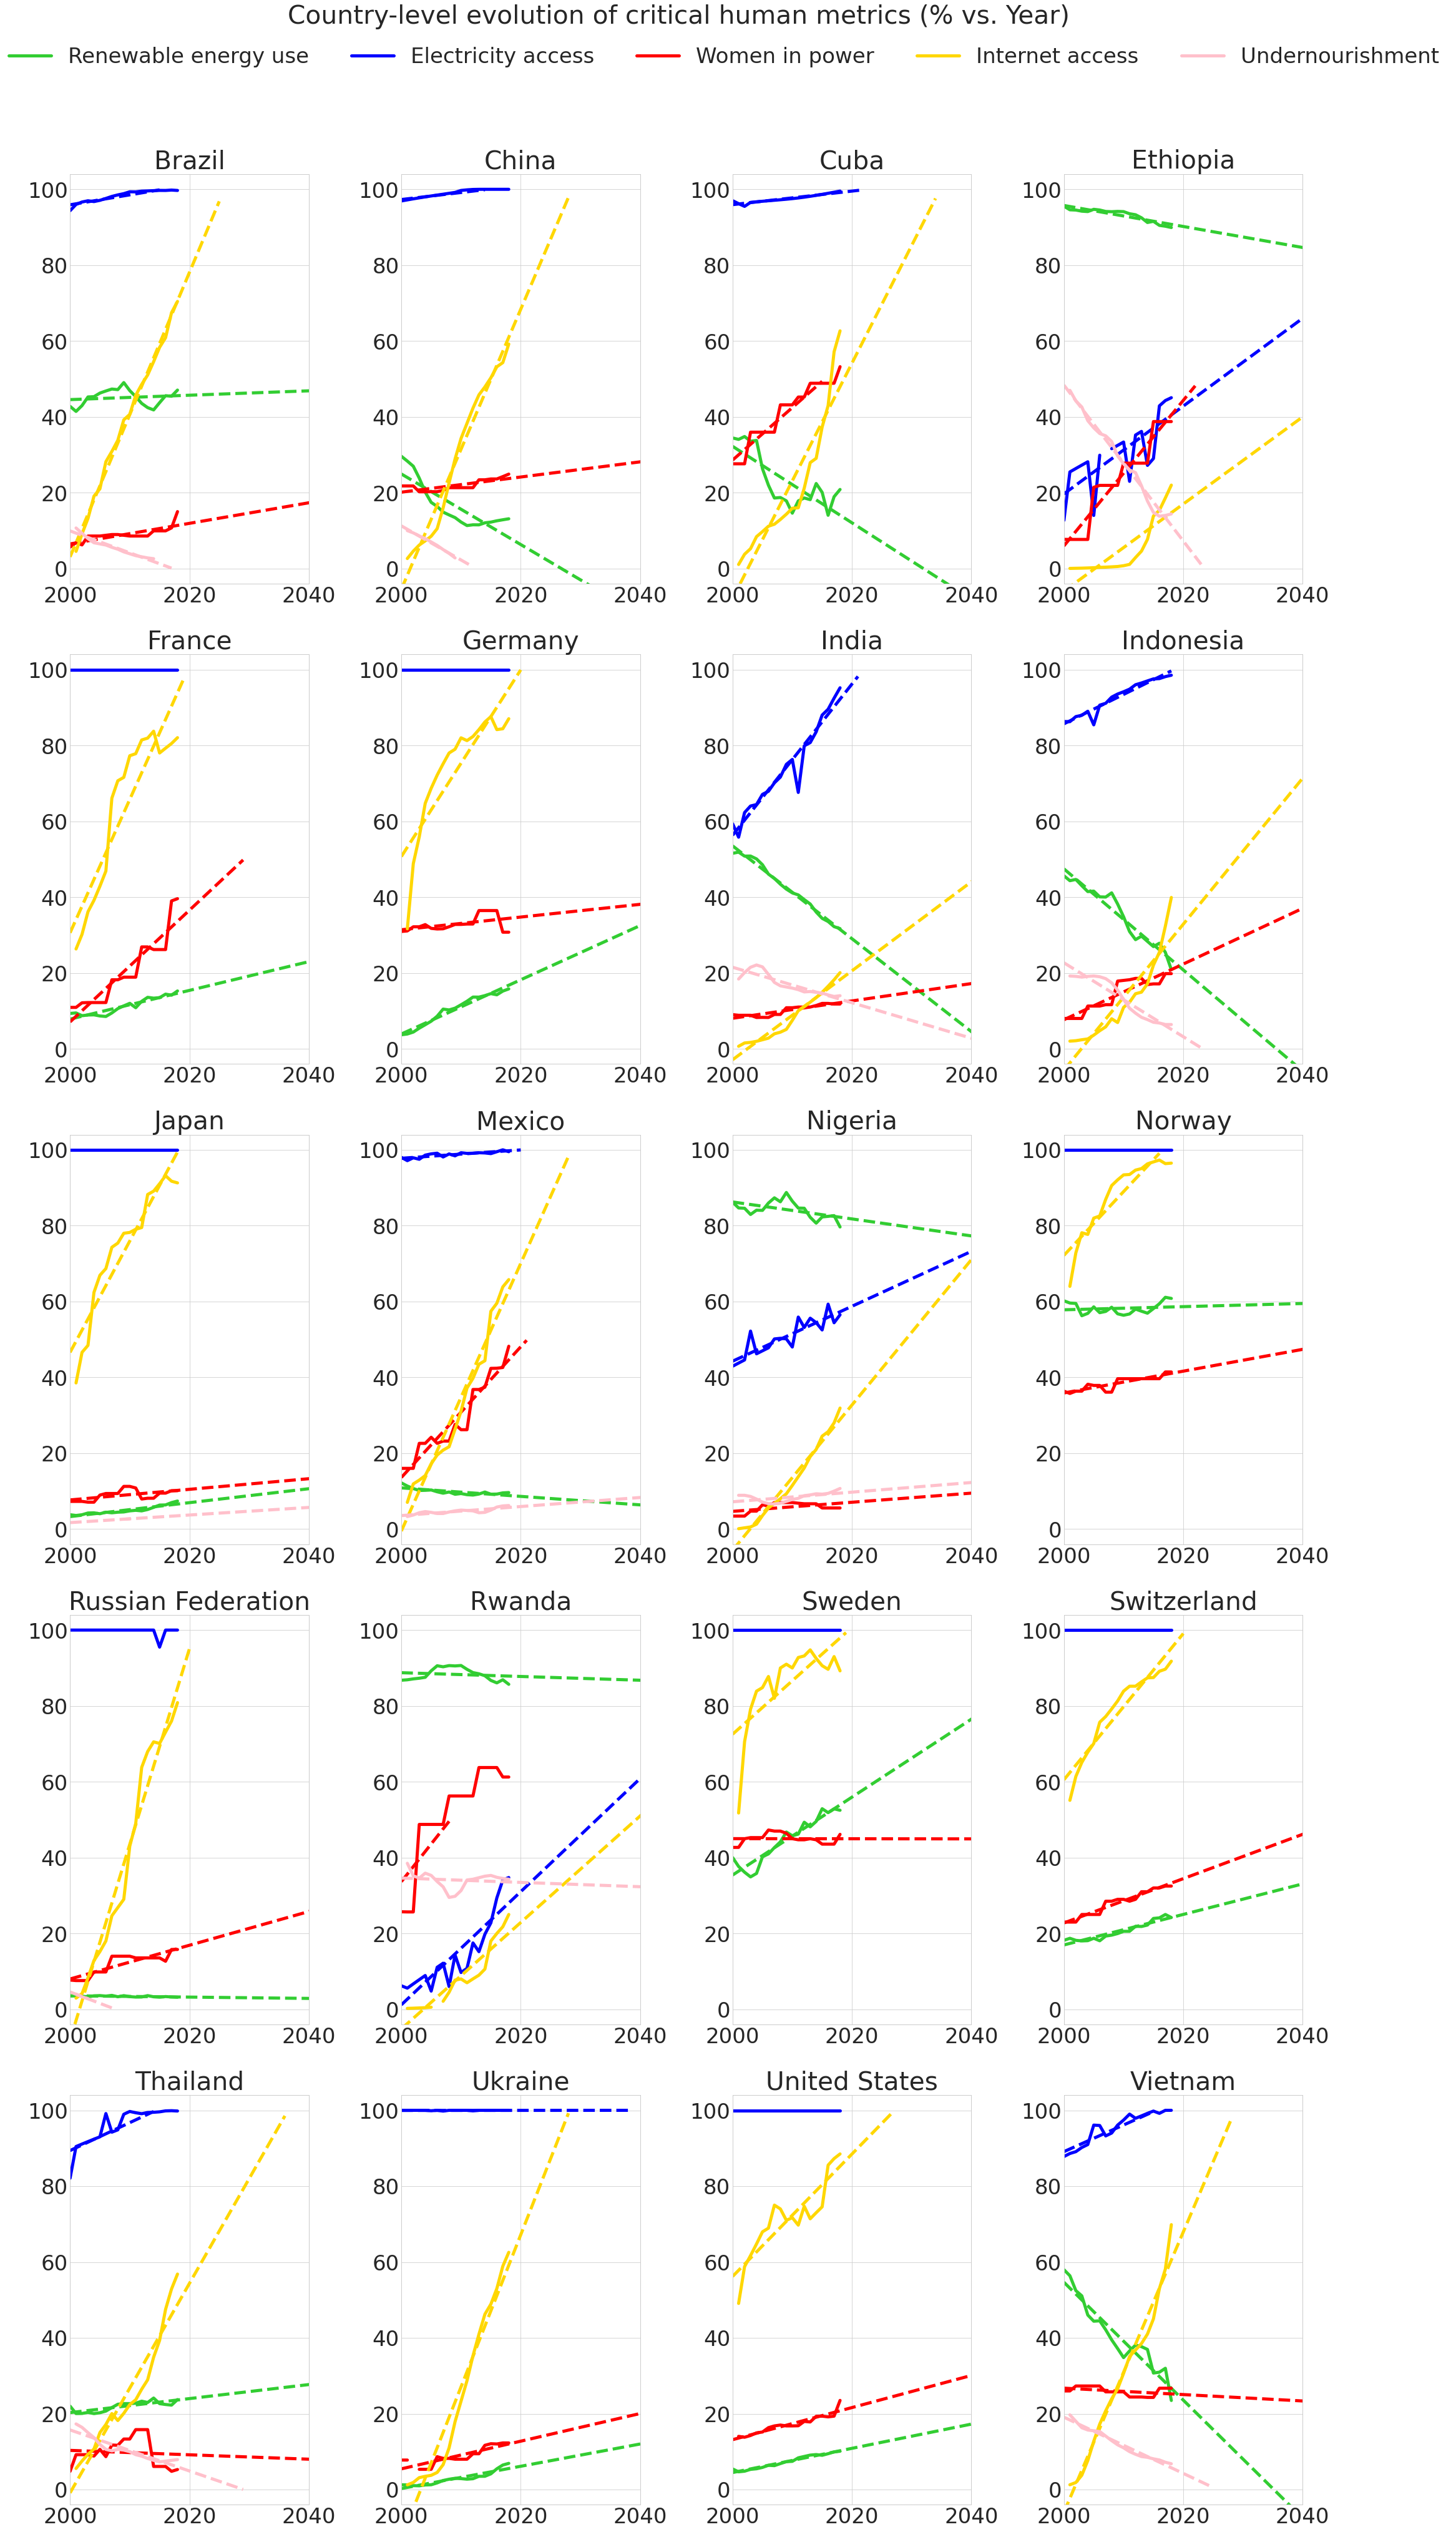

In [16]:
theme = "seaborn-whitegrid" if daytime else "dark_background"
plt.style.use([theme])
plt.rcParams.update({'font.size': 34})
fig = plt.figure(figsize=(30, 55))
plt.suptitle(
    "Country-level evolution of critical human metrics (% vs. Year)",
    y=1.03
)
plot_cols = 4
plot_rows = int(np.ceil(len(country_ls)/plot_cols))

for i, icountry in enumerate(country_ls):

    country_filter = WICEYU_df["country"] == icountry
    ax = fig.add_subplot(plot_rows, plot_cols, i+1)
    ax.set_title(icountry)

    for ifeature in feature_ls:

        ix = country_predict_dct[icountry][ifeature]["goal_ix"]
        fit = country_predict_dct[icountry][ifeature]["fit"]

        ax.plot(
            WICEYU_df[country_filter]["year"],
            WICEYU_df[country_filter][ifeature],
            color=color_dct[ifeature],
            linewidth=5
        )
        try:
            ax.plot(
                country_predict_dct["year"][:ix],
                fit[:ix],
                '--',
                color=color_dct[ifeature],
                label="_nolegend_",
                linewidth=5
            )
        except (ValueError, TypeError):
            pass

        ax.set_xlim(2000, 2040)
        ax.set_ylim(-4, 104)

plt.figlegend(
    labels=legend_dct.values(),
    loc=[0, 0.97],
    ncol=5
)
fig.tight_layout()

A few miscellaneous observations and thoughts:

Linear fitting appears to be not too far from the truth for most cases. However, as noted before, internet access seems to be accelerating in these times, as can be seen in the curves relating to Cuba, Ethiopia, Indonesia, and Vietnam.

Of course, simple linear fitting to predict the world's future is not a robust method, and many future parameters may lead to stalling or acceleration regarding the shown metrics. Nevertheless, it offers some interesting insights into the current world status, e.g.:

* Some countries have already achieved gender sovereignty equality, e.g., Cuba and Rwanda.

* Some countries score high in gender equality and energy sustainability metrics but seem to have stopped progression before reaching the ultimate goals, e.g. Norway <-> energy sustainability & Sweden <-> gender equality.
Japan is evolving painfully slowly regarding gender equality and energy sustainability.

Which countries will achieve full energy sustainability first? Here the list:

In [17]:
country_predict_df[(country_predict_df["energy"] != 0)].sort_values(
    by="energy"
).iloc[:18,]["energy"]

Montenegro                   2035
Iceland                      2035
Uruguay                      2049
Zimbabwe                     2052
Gabon                        2056
Comoros                      2057
Denmark                      2062
Sweden                       2063
Moldova                      2066
Korea, Dem. People's Rep.    2077
Finland                      2080
Lithuania                    2089
Austria                      2107
Belize                       2120
Italy                        2121
Hungary                      2130
Bulgaria                     2134
Germany                      2135
Name: energy, dtype: int64

* Montenegro and Iceland are leading the pack and look to be heroic pioneers; they are more than a decade ahead of the rest.

* Italy and Germany also make the top of the list; nevertheless, they are still a century away from this crucial milestone.

Which inspiring countries have already achieved gender equality regarding sovereignty? Let's find out:

In [18]:
country_predict_df[(country_predict_df["women"] <= 2022) & (
    country_predict_df["women"] != 0)].sort_values(by="women")["women"]

Rwanda       2009.0
Cuba         2016.0
Bolivia      2018.0
Nicaragua    2020.0
Senegal      2021.0
Ecuador      2022.0
Mexico       2022.0
Name: women, dtype: float64

Which countries are next in line? Here we go:

In [19]:
country_predict_df[(country_predict_df["women"] > 2022) & (
    country_predict_df["women"] != 0)].sort_values(
        by="women"
    ).iloc[:18, ]["women"]

Ethiopia           2023.0
South Africa       2024.0
North Macedonia    2024.0
Angola             2025.0
Serbia             2025.0
Nepal              2025.0
Slovenia           2026.0
Burundi            2028.0
Italy              2029.0
Belgium            2029.0
Cameroon           2029.0
Tanzania           2029.0
Algeria            2029.0
El Salvador        2030.0
France             2030.0
Portugal           2031.0
Namibia            2031.0
Zimbabwe           2031.0
Name: women, dtype: float64

Let's end this notebook on this positive news: following in the footsteps of African countries such as Rwanda and Senegal, as well as South American countries like Bolivia, Nicaragua and Ecuador, many other countries are about to reach gender equality regarding sovereignty, especially in Europe: North Macedonia, Serbia, Slovenia, Italy, Belgium, France, and Portugal.